In [2]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

import warnings
warnings.filterwarnings('ignore')



In [5]:
from google.colab import files
uploaded = files.upload()
url = "https://raw.githubusercontent.com/blastchar/telco-customer-churn/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"
import pandas as pd
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv


In [9]:
df.drop_duplicates(inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)



In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')

df = pd.get_dummies(df, columns=categorical_cols)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [11]:
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72], labels=['0-12', '12-24', '24-48', '48-60', '60-72'])
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# 7. Model Training

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    print(f"--- {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1081
           1       0.63      0.54      0.58       321

    accuracy                           0.82      1402
   macro avg       0.75      0.72      0.73      1402
weighted avg       0.81      0.82      0.82      1402

ROC-AUC: 0.8475249350866424

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1081
           1       0.57      0.51      0.54       321

    accuracy                           0.80      1402
   macro avg       0.71      0.70      0.70      1402
weighted avg       0.79      0.80      0.79      1402

ROC-AUC: 0.8225307708046952

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1081
           1       0.56      0.54      0.55       321

    accuracy                           0.80      1402
   m

In [15]:
# 8. Model Evaluation
models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    print(f"--- {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1081
           1       0.63      0.54      0.58       321

    accuracy                           0.82      1402
   macro avg       0.75      0.72      0.73      1402
weighted avg       0.81      0.82      0.82      1402

ROC-AUC: 0.8475249350866424

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1081
           1       0.57      0.51      0.54       321

    accuracy                           0.80      1402
   macro avg       0.71      0.70      0.70      1402
weighted avg       0.79      0.80      0.79      1402

ROC-AUC: 0.8225307708046952

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1081
           1       0.56      0.54      0.55       321

    accuracy                           0.80      1402
   m

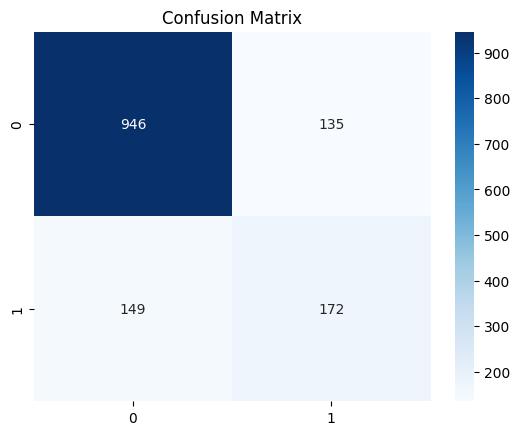

In [16]:
# 9. Confusion Matrix for Best Model
best_model = xgb
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

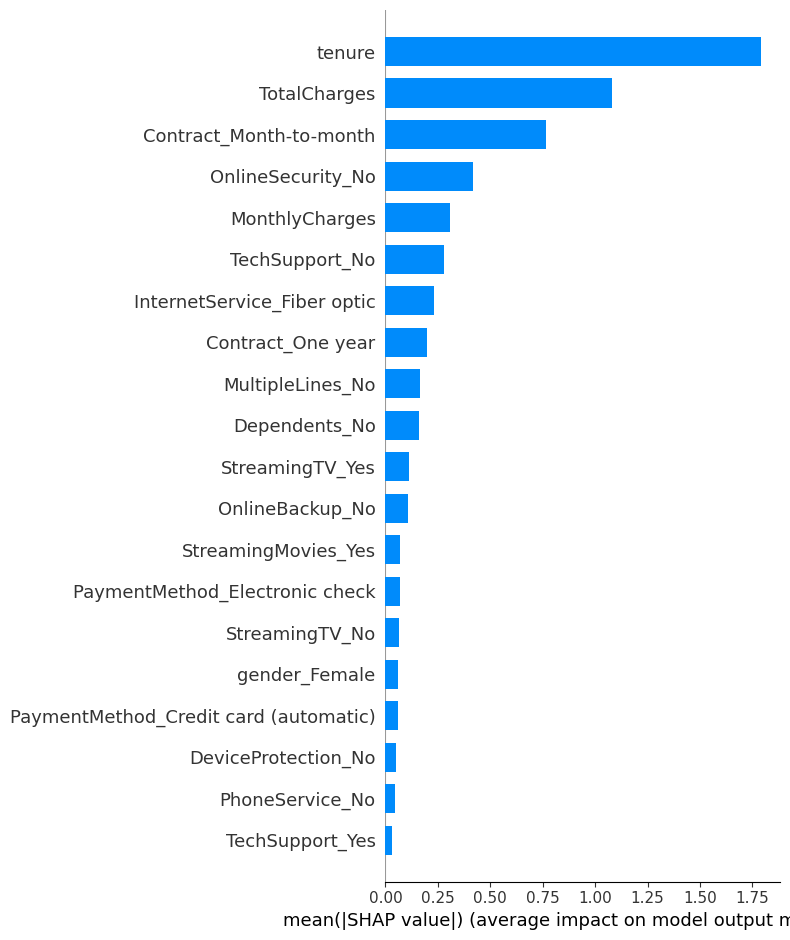

In [19]:
# 10. SHAP Values for Model Interpretation
# SHAP works best with unscaled data for interpretation
# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")


In [20]:
# 11. (Optional) Deploy with Streamlit
# Save this script as app.py and run with: streamlit run app.py

"""
import streamlit as st
st.title("Customer Churn Predictor")
# Add widgets and model loading code here...
"""

'\nimport streamlit as st\nst.title("Customer Churn Predictor")\n# Add widgets and model loading code here...\n'